## 簡介
這個專案「兩百個國家、兩百年、四分鐘」復刻了名聞遐邇的 Hans Rosling's 200 Countries, 200 Years, 4 Minutes 資料視覺化，我們使用了 pandas 與 sqlite3 建立了資料庫，利用 matplotlib 進行概念驗證，最後以 plotly.express 做出成品。

## 如何重現
1. 安裝 anaconda  
2. 依據 environment.yml 建立環境：  
```bash
conda env create -f environment.yml 
```

3. 將資料夾中的四個 CSV 檔案放置於工作目錄中。  

4. 啟動環境並執行以下命令：  
```bash
python create_gapminder_db.py
```
即可在資料夾中建立 gapminder.db。

5. 再次啟動環境並執行以下命令：  
```bash
python plot_with_px.py
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# gdp_pcap = pd.read_csv("ddf--datapoints--gdp_pcap--by--country--time.csv",sep=",")
# life = pd.read_csv("ddf--datapoints--lex--by--country--time.csv",sep=",")
# pop = pd.read_csv("ddf--datapoints--pop--by--country--time.csv",sep=",")
# geo =  pd.read_csv("ddf--entities--geo--country.csv",sep=",")
# gdp_pcap.to_csv("gdp_pcap.csv")
# life.to_csv("life.csv")
# pop.to_csv("pop.csv")
# geo.to_csv("geo.csv")

In [3]:
# # 把資料用dict的形式儲存
# data_list = [gdp_pcap,life,pop,geo]
# name_list = ["gdp_pcap","life","pop","geo"]
# dic = {}
# for name,data in zip(name_list,data_list):
#     dic[name] = data    

In [4]:
# # 把資料放到SQL裡面

# import sqlite3
# # 建立資料庫連結
# connection = sqlite3.connect("data_sql/gapminder.db")       # gapminder.db是名稱

# # 把資料轉到SQL裡面
# for name,data in dic.items():
#     # index = False代表不要放入index,不要放入index,if_exists = "replace"代表如果原本資料庫裡有一樣的就直接取代
#     data.to_sql(name = name,con = connection, index = False, if_exists = "replace")

# # 關閉資料庫連結
# connection.close()


In [5]:
# connection = sqlite3.connect("data_sql/gapminder.db")  
# drop_view_sql = """
# DROP VIEW IF EXISTS plotting;
# """  

# create_view_sql = """
# CREATE VIEW plotting AS
# SELECT geo.name AS country_name,
#     geo.world_4region AS continent,
#     gdp_pcap.time AS dt_year,
#     gdp_pcap.gdp_pcap AS gdp_per_capita,
#     life.lex AS life_expectancy,
#     pop.pop AS population
# FROM gdp_pcap 
# JOIN geo ON gdp_pcap.country = geo.country
# JOIN life ON gdp_pcap.country = life.country AND gdp_pcap.time = life.time
# JOIN pop ON gdp_pcap.country = pop.country AND gdp_pcap.time = pop.time
# WHERE gdp_pcap.time < 2024;
# """
# cur = connection.cursor()
# cur.execute(drop_view_sql)
# cur.execute(create_view_sql)

# connection.close()


In [6]:
# 整理成class 完整結構化 一鍵搞定

class creategapminderDB:
    def __init__(self):
        self.name_list = ["gdp_pcap","life","pop","geo"]

    def import_as_dataframe(self):
        import pandas as pd
        dict_gpmDB = {}
        for name in self.name_list:
            temp_data = pd.read_csv(f"{name}.csv")
            dict_gpmDB[name] = temp_data
        return dict_gpmDB
    
    def create_database(self):
        import sqlite3
        # 建立資料庫連結
        connection = sqlite3.connect("data_sql/gapminder.db")       # gapminder.db是名稱
        dict_gpmDB = self.import_as_dataframe()
        # 把資料轉到SQL裡面
        for name,data in dict_gpmDB.items():
            # index = False代表不要放入index,不要放入index,if_exists = "replace"代表如果原本資料庫裡有一樣的就直接取代
            data.to_sql(name = name,con = connection, index = False, if_exists = "replace")
        drop_view_sql = """
        DROP VIEW IF EXISTS plotting;
        """  

        create_view_sql = """
        CREATE VIEW plotting AS
        SELECT geo.name AS country_name,
            geo.world_4region AS continent,
            gdp_pcap.time AS dt_year,
            gdp_pcap.gdp_pcap AS gdp_per_capita,
            life.lex AS life_expectancy,
            pop.pop AS population
        FROM gdp_pcap 
        JOIN geo ON gdp_pcap.country = geo.country
        JOIN life ON gdp_pcap.country = life.country AND gdp_pcap.time = life.time
        JOIN pop ON gdp_pcap.country = pop.country AND gdp_pcap.time = pop.time
        WHERE gdp_pcap.time < 2024;
        """
        cur = connection.cursor()
        cur.execute(drop_view_sql)
        cur.execute(create_view_sql)

        connection.close()

create_gapminder_DB = creategapminderDB()
create_gapminder_DB.create_database()

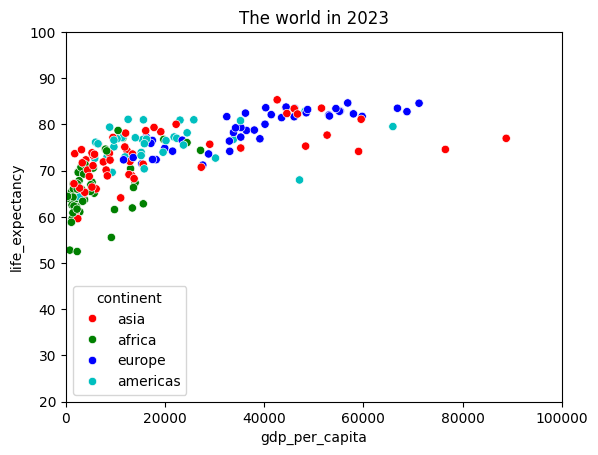

In [7]:
# 驗證資料結構與簡易呈現
import sqlite3
connection = sqlite3.connect("data_sql/gapminder.db")       # gapminder.db是名稱
plotting_df = pd.read_sql("""SELECT * FROM plotting;""",con = connection)
connection.close()

# 簡易呈現
test_year = 2023    # end year = 2023 
# plotting_df["continent"].unique()     # array(['asia', 'africa', 'europe', 'americas'], dtype=object)
color_map = {'asia':'r','africa':'g', 'europe':'b', 'americas':'c'}
plotting_df_temp = plotting_df[plotting_df["dt_year"] == test_year]
sns.scatterplot(data=plotting_df_temp, x="gdp_per_capita", y="life_expectancy",hue="continent",palette=color_map)
plt.xlim(0,100000)
plt.ylim(20,100)
plt.title(f"The world in {test_year}")
plt.show()


In [23]:
# 動態呈現
import plotly.express as px
import nbformat

fig = px.scatter(
    plotting_df,
    x="gdp_per_capita",
    y="life_expectancy",
    color="continent",  # 依照continent欄位區分顏色
    animation_frame="dt_year",  # 動畫的時間軸
    size="population",  # 根據population欄位決定點的大小
    size_max=60,    # 決定點大小的上限
    hover_name="country_name",  # 當游標懸浮在點上時會呈現這個點的主要名稱
    # hover_data="country_name",    # 當游標懸浮在點上時會呈現這個點的所有值
    title="GDP vs Life Expectancy Over Years",  
    color_discrete_map={'asia': 'red', 'africa': 'green', 'europe': 'blue', 'americas': 'cyan'}     # 根據continent的值進行mapping
)
# 調整呈現的xlim ylim調整呈現的xlim ylim
fig.update_layout(
    xaxis=dict(range=[0,100000]),
    yaxis=dict(range=[20,100])
)
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 300  # 每幀持續時間 (毫秒)
fig.show()